In [1]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

# Analyse évolutive des journaux de serveurs Web avec Apache Spark
Apache Spark est un cadre excellent et idéal pour les querelles, l'analyse et la modélisation des données structurées et non structurées - à l'échelle ! Dans ce tutoriel, nous nous concentrerons sur l'une des études de cas les plus populaires de l'industrie - l'analyse des logs.

En général, les journaux de serveur sont une source de données très courante dans les entreprises et contiennent souvent une mine d'informations et de connaissances exploitables. Les données des journaux proviennent de nombreuses sources dans une entreprise, telles que le web, les clients et les serveurs de calcul, les applications, le contenu généré par les utilisateurs, les fichiers plats. Elles peuvent être utilisées pour surveiller les serveurs, améliorer l'intelligence économique et la connaissance des clients, mettre en place des systèmes de recommandation, détecter les fraudes, et bien d'autres choses encore.

Spark vous permet de vider et de stocker vos journaux dans des fichiers sur disque à peu de frais, tout en fournissant de riches API pour effectuer des analyses de données à l'échelle. Ce cours pratique vous montrera comment utiliser Apache Spark sur des journaux de production réels de la NASA et vous apprendra les techniques de base mais puissantes d'analyse de données exploratoires.

## Partie 1 - Mise en place des dépendances


In [2]:
spark

In [3]:
sqlContext

# Expressions régulières de base


In [4]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<_sre.SRE_Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<_sre.SRE_Match object; span=(25, 36), match=' in PySpark'> 25 36


# Dans cette étude de cas, nous analyserons les ensembles de données des journaux du serveur web du Centre spatial Kennedy de la NASA en Floride. L'ensemble complet des données peut être téléchargé gratuitement ici.

Ces deux ensembles de données contiennent deux mois de toutes les demandes HTTP adressées au serveur WWW du Centre spatial Kennedy de la NASA en Floride. Vous pouvez vous rendre sur le site web et télécharger les fichiers suivants selon vos besoins.

Du 1er au 31 juillet, format ASCII, 20,7 Mo gzip compressés, 205,2 Mo non compressés : ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz
Du 04 août au 31 août, format ASCII, 21,8 Mo gzip compressés, 167,8 Mo non compressés : ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz
Assurez-vous que les deux fichiers se trouvent dans le même répertoire que ce carnet.



# Partie 2 - Chargement et visualisation de l'ensemble des données du journal de bord de la NASA
Étant donné que nos données sont stockées dans le chemin mentionné ci-dessous, chargeons-les dans un DataFrame. Nous allons procéder par étapes. Tout d'abord, nous utiliserons sqlContext.read.text() ou spark.read.text() pour lire le fichier texte. Cela produira un DataFrame avec une seule colonne de chaîne de caractères appelée value.





In [5]:
import glob

raw_data_files = glob.glob('*gz')
raw_data_files

['NASA_access_log_Aug95.gz', 'NASA_access_log_Jul95.gz']

Regard sur les métadonnées de notre cadre de données

In [6]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [7]:
type(base_df)

pyspark.sql.dataframe.DataFrame

Vous pouvez également convertir une trame de données en un RDD si nécessaire


In [8]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

## Visualiser des exemples de données dans notre cadre de données
Il semble qu'il faille l'analyser et l'analyser !

In [9]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

L'obtention de données à partir d'un RDD est légèrement différente. Vous pouvez voir comment la représentation des données est différente dans les RDD suivants


In [10]:
base_df_rdd.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

In [11]:
!python --version


Python 2.7.17


# Partie 3 - Data Wrangling
Dans cette section, nous allons essayer de nettoyer et d'analyser notre ensemble de données de journal afin d'extraire réellement des attributs structurés avec des informations significatives de chaque message de journal.

Compréhension des données
Si vous êtes familier avec les journaux de serveur web, vous reconnaîtrez que les données affichées ci-dessus sont au format de journal commun.

Les champs sont les suivants : remotehost rfc931 authuser [date] "request" status bytes

Capture ecran

Nous devrons utiliser certaines techniques spécifiques pour analyser, faire correspondre et extraire ces attributs des données du journal


# Analyse et extraction de données avec des expressions régulières
Ensuite, nous devons l'analyser en colonnes individuelles. Nous utiliserons la fonction spéciale intégrée regexp_extract() pour effectuer l'analyse. Cette fonction fait correspondre une colonne à une expression régulière avec un ou plusieurs groupes de capture et vous permet d'extraire un des groupes correspondants. Nous utiliserons une expression régulière pour chaque champ que nous souhaitons extraire.

Vous devez avoir entendu ou utilisé pas mal d'expressions régulières à ce jour. Si vous trouvez les expressions régulières déroutantes (et elles peuvent certainement l'être), et que vous souhaitez en savoir plus à leur sujet, nous vous recommandons de consulter le site web de RegexOne. Vous pouvez également consulter le livre de cuisine Regular Expressions Cookbook, de Goyvaerts et Levithan, qui vous servira de référence.

Jetons un coup d'œil sur les dimensions de notre ensemble de données

In [12]:
print((base_df.count(), len(base_df.columns)))


(3461613, 1)


Extraction et examen de quelques exemples de messages du journal

In [13]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

##  Extraction des noms d'hôtes
Essayons d'écrire quelques expressions régulières pour extraire le nom d'hôte des journaux

In [14]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

## Extraction des horodatages
Essayons maintenant d'utiliser des expressions régulières pour extraire les champs d'horodatage des journaux

In [15]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

## Extraction de la méthode de requête HTTP, des URI et du protocole
Essayons maintenant d'utiliser des expressions régulières pour extraire les méthodes de requête HTTP, les URI et les champs de modèles de protocole des journaux

In [16]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

## Extraction des codes d'état HTTP
Essayons maintenant d'utiliser des expressions régulières pour extraire les codes d'état HTTP des journaux

In [17]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


##  Extraction de la taille du contenu de la réponse HTTP
Essayons maintenant d'utiliser des expressions régulières pour extraire la taille du contenu de la réponse HTTP des journaux

In [18]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']


## Tout mettre ensemble
Essayons maintenant d'exploiter tous les modèles d'expression régulière que nous avons construits précédemment et utilisons la méthode regexp_extract(...) pour construire notre dataframe avec tous les attributs de log proprement extraits dans leurs propres colonnes séparées.

In [19]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

# Trouver les valeurs manquantes 
Les valeurs manquantes et nulles sont le fléau de l'analyse des données et de l'apprentissage machine. Voyons comment notre logique d'analyse et d'extraction des données a fonctionné. Tout d'abord, vérifions qu'il n'y a pas de lignes nulles dans le cadre de données original.

In [20]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())

0

Si notre analyse et notre extraction des données ont fonctionné correctement, nous ne devrions pas avoir de lignes avec des valeurs potentiellement nulles. Essayons de mettre cela à l'épreuve !

In [21]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33905

Aïe ! On dirait que nous avons plus de 33 000 valeurs manquantes dans nos données ! Pouvons-nous gérer cela ?

N'oubliez pas qu'il ne s'agit pas d'une trame de données pandas ordinaire que vous pouvez interroger directement et obtenir les colonnes qui sont nulles. Notre soi-disant grand ensemble de données réside sur un disque qui peut potentiellement être présent dans plusieurs nœuds d'un groupe d'étincelles. Alors comment savoir quelles colonnes sont potentiellement nulles ?

##  Trouver des comptes nuls
Nous pouvons généralement utiliser la technique suivante pour savoir quelles colonnes ont des valeurs nulles.

In [22]:
logs_df.columns


['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [23]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



On dirait qu'il manque une valeur dans la colonne "status" et que tout le reste se trouve dans la colonne "content_size". Voyons voir si nous pouvons trouver ce qui ne va pas !



## Traitement des annulations dans le statut HTTP
Notre première expression régulière d'analyse pour la colonne d'état était :

regexp_extract('value', r'\s(\d{3})\s', 1).cast('integer').alias('status')

Se pourrait-il qu'il y ait plus de chiffres qui rendent notre expression régulière erronée ? ou le point de données lui-même est-il mauvais ? Essayons de le découvrir !

Note : Dans l'expression ci-dessous, ~ signifie "pas".

In [24]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

1

In [25]:
null_status_df.show(truncate=False)


+--------+
|value   |
+--------+
|alyssa.p|
+--------+



In [26]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|    |         |      |        |        |null  |null        |
+----+---------+------+--------+--------+------+------------+



Il semble que le dossier lui-même soit un dossier incomplet sans aucune information utile, la meilleure option serait de laisser tomber ce dossier comme suit !



In [27]:
logs_df.count()

3461613

In [28]:

logs_df = logs_df[logs_df['status'].isNotNull()] 
logs_df.count()

3461612

In [29]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



## Traitement des annulations dans la taille du contenu HTTP
Sur la base de notre expression régulière précédente, notre expression régulière originale d'analyse pour la colonne content_size était :

regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')

Pourrait-il y avoir des données manquantes dans notre ensemble de données initial lui-même ? Essayons de le découvrir !

## Découvrez les enregistrements dans notre base de données avec les tailles de contenu potentiellement manquantes

In [30]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

33905

In [31]:
null_content_size_df.take(10)

[Row(value='dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -'),
 Row(value='dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='link097.txdirect.net - - [01/Jul/1995:00:05:06 -0400] "GET /shuttle HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:13 -0400] "GET /shuttle/missions/sts-78/news HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:58 -0400] "GET /shuttle/missions/sts-72/news HTTP/1.0" 302 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:19 -0400] "GET /pub/winvn/readme.txt HTTP/1.0" 404 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:28 -0400] "GET

Il est tout à fait évident que les mauvais enregistrements de données brutes correspondent à des réponses d'erreur, où aucun contenu n'a été renvoyé et où le serveur a émis un "-" pour le champ content_size.

Puisque nous ne voulons pas écarter ces lignes de notre analyse, imputons ou remplissons les à 0.

## Fixez les lignes dont le champ content_size est nul
La solution la plus simple est de remplacer les valeurs nulles dans logs_df par 0, comme nous l'avons vu précédemment. L'API Spark DataFrame fournit un ensemble de fonctions et de champs spécialement conçus pour travailler avec des valeurs nulles, parmi lesquels

fillna(), qui remplit les valeurs nulles avec des valeurs non nulles spécifiées.
na, qui renvoie un objet DataFrameNaFunctions avec de nombreuses fonctions permettant de travailler sur des colonnes nulles.
Il existe plusieurs façons d'invoquer cette fonction. La plus simple consiste à remplacer toutes les colonnes nulles par des valeurs connues. Mais, par sécurité, il est préférable de passer un dictionnaire Python contenant les mappages (nom_colonne, valeur). C'est ce que nous allons faire. Voici un exemple tiré de la documentation

Maintenant, nous utilisons cette fonction et remplissons toutes les valeurs manquantes dans le champ content_size avec 0 !


In [32]:
logs_df = logs_df.na.fill({'content_size': 0})

Maintenant, en supposant que tout ce que nous avons fait jusqu'à présent a fonctionné, nous ne devrions pas avoir de valeurs manquantes \Nnn'ayant pas de valeur nulle dans notre ensemble de données. Vérifions cela !



In [33]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



Regardez ça, pas de valeurs manquantes !

## Traitement des champs temporels (Timestamp)
Maintenant que nous disposons d'une DataFrame propre et analysée, nous devons analyser le champ d'horodatage pour obtenir un horodatage réel. L'heure du Common Log Format est quelque peu hors norme. Une fonction définie par l'utilisateur (UDF) est la façon la plus simple de l'analyser.

In [45]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [46]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

AnalysisException: cannot resolve '`timestamp`' given input columns: [content_size, endpoint, host, method, protocol, status, time];;
'Project ['timestamp]
+- Project [host#16, method#18, endpoint#19, protocol#20, status#21, content_size#333, time#416]
   +- Project [host#16, timestamp#17, method#18, endpoint#19, protocol#20, status#21, content_size#333, cast(parse_clf_time(timestamp#17) as timestamp) AS time#416]
      +- Project [host#16, timestamp#17, method#18, endpoint#19, protocol#20, status#21, coalesce(content_size#22, cast(0 as int)) AS content_size#333]
         +- Filter isnotnull(status#21)
            +- Project [regexp_extract(value#0, (^\S+\.[\S+\.]+\S+)\s, 1) AS host#16, regexp_extract(value#0, \[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})], 1) AS timestamp#17, regexp_extract(value#0, \"(\S+)\s(\S+)\s*(\S*)\", 1) AS method#18, regexp_extract(value#0, \"(\S+)\s(\S+)\s*(\S*)\", 2) AS endpoint#19, regexp_extract(value#0, \"(\S+)\s(\S+)\s*(\S*)\", 3) AS protocol#20, cast(regexp_extract(value#0, \s(\d{3})\s, 1) as int) AS status#21, cast(regexp_extract(value#0, \s(\d+)$, 1) as int) AS content_size#22]
               +- Relation[value#0] text


In [ ]:
[parse_clf_time(item) for item in sample_ts]

In [ ]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

In [ ]:
logs_df.printSchema()

In [39]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11


In [40]:
logs_df.limit(5).toPandas()


,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11


In [41]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11


Mettons maintenant en cache logs_df puisque nous l'utiliserons largement pour notre section d'analyse des données dans la prochaine partie !

In [42]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

##  Partie 4 - Analyse des données sur nos journaux Web
Maintenant que nous disposons d'un DataFrame contenant le fichier journal analysé en tant que cadre de données, nous pouvons effectuer une analyse exploratoire des données (AED) intéressante

Statistiques sur la taille du contenu
Calculons quelques statistiques sur la taille des contenus renvoyés par le serveur web. En particulier, nous aimerions savoir quelles sont les tailles moyennes, minimales et maximales des contenus.

Nous pouvons calculer les statistiques en appelant .describe() sur la colonne content_size de logs_df. La fonction .describe() renvoie le nombre, la moyenne, stddev, min et max d'une colonne donnée.

In [43]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949228
3,min,0
4,max,6823936


On peut aussi utiliser SQL pour calculer directement ces statistiques. Vous pouvez explorer de nombreuses fonctions utiles dans le module pyspark.sql.functions dans la documentation.

Après avoir appliqué la fonction .agg(), nous appelons toPandas() pour extraire et convertir le résultat en une trame de données pandas qui a un meilleur formatage sur les carnets Jupyter

In [47]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


## Analyse du code d'état HTTP
Ensuite, examinons les valeurs des codes de statut qui apparaissent dans le journal. Nous voulons savoir quelles valeurs de code de statut apparaissent dans les données et combien de fois.

Nous commençons à nouveau par log_df, puis nous regroupons les données en fonction de la colonne d'état, nous appliquons la fonction d'agrégation .count() et nous les trions en fonction de la colonne d'état.

In [50]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [51]:
print('Total distinct HTTP Status Codes:', status_freq_df.count())

Total distinct HTTP Status Codes: 8


In [52]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,3100524
2,304,266773
1,302,73070
5,404,20899
4,403,225
6,500,65
7,501,41
3,400,15


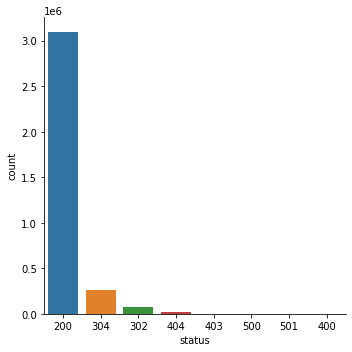

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [54]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|3100524|14.947081687429097|
|   302|  73070|11.199173164785263|
|   304| 266773|12.494153388502301|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20899| 9.947456589918252|
|   500|     65| 4.174387269895637|
|   501|     41| 3.713572066704308|
+------+-------+------------------+



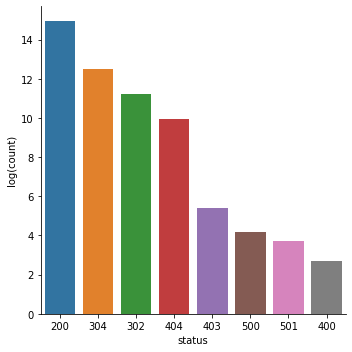

In [55]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

## Analyser les hôtes fréquents
Examinons les hôtes qui ont accédé au serveur fréquemment. Nous essaierons d'obtenir le nombre total d'accès par chaque hôte, puis nous trierons par nombre et n'afficherons que les dix hôtes les plus fréquents.

In [56]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



In [57]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['host']

''

Il semble que nous ayons quelques chaînes vides comme l'un des meilleurs noms d'hôtes ! Cela nous apprend une leçon précieuse, à savoir qu'il ne faut pas se contenter de vérifier les caractères nuls mais aussi les chaînes potentiellement vides lors des échanges de données.

## Afficher les 20 principaux points de terminaison les plus fréquents
Maintenant, visualisons le nombre d'accès aux points finaux (URI) dans le journal. Pour effectuer cette tâche, nous commençons avec notre log_df et nous regroupons par la colonne des points finaux, nous agrégeons par nombre, et nous trions par ordre décroissant comme la question précédente.

In [58]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

In [59]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,208714
1,/images/KSC-logosmall.gif,164970
2,/images/MOSAIC-logosmall.gif,127908
3,/images/USA-logosmall.gif,127074
4,/images/WORLD-logosmall.gif,125925
5,/images/ksclogo-medium.gif,121572
6,/ksc.html,83909
7,/images/launch-logo.gif,76006
8,/history/apollo/images/apollo-logo1.gif,68896
9,/shuttle/countdown/,64736


## Les dix principaux paramètres d'erreur
Quels sont les dix principaux points terminaux demandés qui n'ont pas de code de retour 200 (HTTP Status OK) ?

Nous créons une liste triée contenant les terminaux et le nombre de fois qu'ils ont été consultés avec un code de retour non 200 et nous affichons les dix premiers.

In [60]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [61]:
error_endpoints_freq_df.show(truncate=False)


+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



## Nombre total d'hôtes uniques
Quel a été le nombre total d'hôtes uniques qui ont visité le site web de la NASA au cours de ces deux mois ? Nous pouvons le découvrir en effectuant quelques transformations.

In [62]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

137933


Nombre d'hôtes quotidiens uniques
Pour un exemple avancé, examinons une façon de déterminer le nombre d'hôtes uniques dans l'ensemble du journal au jour le jour. Ce calcul nous donnera le nombre d'hôtes uniques par jour.

Nous aimerions disposer d'une DataFrame triée par jour croissant du mois, qui comprendrait le jour du mois et le nombre d'hôtes uniques associé pour ce jour.

Pensez aux étapes que vous devez effectuer pour compter le nombre d'hôtes différents qui font des demandes chaque jour. Comme le journal ne couvre qu'un seul mois, vous pouvez ignorer le mois. Vous pouvez utiliser la fonction jour du mois dans le module pyspark.sql.functions (que nous avons déjà importé sous la forme F.

host_day_df

Un DataFrame à deux colonnes

In [63]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |1  |
|unicomp6.unicomp.net|1  |
|199.120.110.21      |1  |
|burger.letters.com  |1  |
|199.120.110.21      |1  |
+--------------------+---+
only showing top 5 rows



host_day_distinct_df

Cette DataFrame a les mêmes colonnes que host_day_df, mais avec les lignes en double (day, host) supprimées.

In [64]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+-----------------------+---+
|host                   |day|
+-----------------------+---+
|129.94.144.152         |1  |
|slip1.yab.com          |1  |
|205.184.190.47         |1  |
|204.120.34.71          |1  |
|ppp3_130.bekkoame.or.jp|1  |
+-----------------------+---+
only showing top 5 rows



In [65]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,7609
1,2,4858
2,3,10238
3,4,9411
4,5,9640
...,...,...
26,27,6846
27,28,6090
28,29,4825
29,30,5265


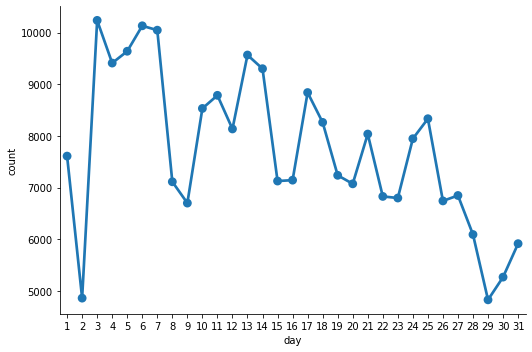

In [66]:
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

# Nombre moyen de demandes quotidiennes par hôte
Dans l'exemple précédent, nous avons étudié un moyen de déterminer le nombre d'hôtes uniques dans l'ensemble du journal au jour le jour. Essayons maintenant de trouver le nombre moyen de requêtes effectuées par jour par hôte sur le site web de la NASA en nous basant sur nos journaux.

Nous aimerions obtenir un DataFrame trié par jour croissant du mois, qui comprendrait le jour du mois et le nombre moyen associé de demandes faites pour ce jour par hôte.

In [67]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
...,...,...,...,...
26,27,94503,6846,13.804119
27,28,82617,6090,13.566010
28,29,67988,4825,14.090777
29,30,80641,5265,15.316429


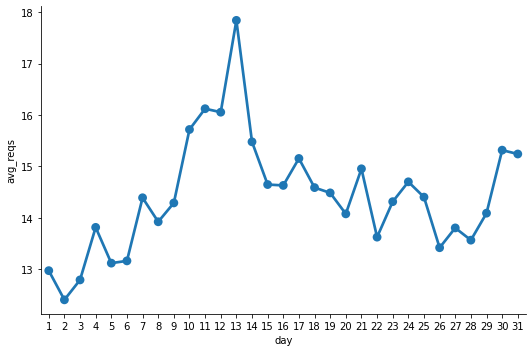

In [68]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

## Compter 404 codes de réponse
Créez une DataFrame contenant uniquement les enregistrements de journal avec un code de statut 404 (Not Found).

Nous veillons à mettre en cache() la dataframe not_found_df comme nous l'utiliserons dans le reste des exemples ici.

### Combien d'enregistrements 404 y a-t-il dans le journal ?

In [69]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 20899


## Liste des vingt meilleurs points terminaux du code de réponse 404
En utilisant la DataFrame contenant uniquement les enregistrements de journal avec un code de réponse 404 que nous avons mis en cache précédemment, nous allons maintenant imprimer une liste des vingt principaux terminaux qui génèrent le plus d'erreurs 404.

N'oubliez pas que les paramètres les plus importants doivent être triés dans l'ordre suivant

In [70]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |683  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |428  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

## Liste des vingt meilleurs hôtes de codes de réponse 404
En utilisant la DataFrame qui ne contient que les enregistrements de journal avec un code de réponse 404 que nous avons mis en cache précédemment, nous allons maintenant imprimer une liste des vingt principaux hôtes qui génèrent le plus d'erreurs 404.

N'oubliez pas que les hôtes les plus importants doivent être triés dans l'ordre suivant

In [71]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|dialip-217.den.mmc.com     |62   |
|www-b4.proxy.aol.com       |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|www-d2.proxy.aol.com       |59   |
|piweba2y.prodigy.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



## Visualisation de 404 erreurs par jour
Examinons maintenant nos 404 enregistrements dans le temps (par temps). Comme dans l'exemple montrant le nombre d'hôtes quotidiens uniques, nous allons décomposer les 404 requêtes par jour et obtenir les comptes quotidiens triés par jour dans errors_by_date_sorted_df.

In [72]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
...,...,...
26,27,706
27,28,504
28,29,420
29,30,571


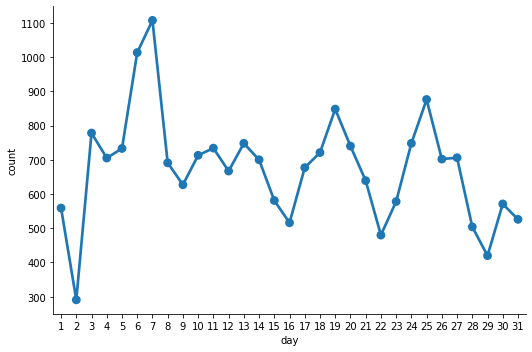

In [73]:
c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

## Les trois premiers jours pour 404 erreurs
Quels sont les trois premiers jours du mois où le nombre d'erreurs est le plus élevé (404) ? Nous pouvons utiliser notre fichier erreurs_par_date_trié_df créé précédemment pour cela

In [74]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



## Visualisation des erreurs horaires 404
En utilisant le DataFrame not_found_df que nous avons mis en cache précédemment, nous allons maintenant regrouper et trier par heure de la journée dans un ordre croissant, pour créer un DataFrame contenant le nombre total de 404 réponses pour les requêtes HTTP pour chaque heure de la journée (minuit commence à 0)

In [75]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

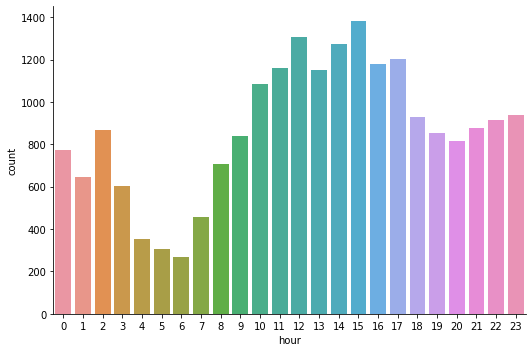

In [76]:

c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

# Réinitialiser les lignes maximales affichées dans les pandas


In [77]:
pd.set_option('max_rows', def_mr)